<a href="https://colab.research.google.com/github/LoQiseaking69/SephsBIOME/blob/master/Docs/Model/Tests/Utils/notebooks/SynthDGenV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Dataset Generation for NLP and Robotic Kinematics

This notebook generates a synthetic dataset optimized for combined NLP and robotic kinematics tasks in a reinforcement learning model. The dataset includes both textual and sensor data, with feature engineering applied to enhance its suitability for machine learning tasks.

In [ ]:
%%capture
!pip install markovify

## NLP Data Generation Using Brown Corpus

In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import nltk
from nltk.corpus import brown
import markovify
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download the 'brown' corpus from nltk
nltk.download('brown')
nltk.download('punkt')
nltk.download('stopwords')

# Save the brown corpus to a CSV file
def save_brown_corpus(file_path):
    try:
        # Extracting sentences from the brown corpus
        brown_sentences = [' '.join(words) for words in brown.sents()]
        # Converting to DataFrame
        df = pd.DataFrame(brown_sentences, columns=['sentence'])
        # Saving to CSV
        df.to_csv(file_path, index=False)
        return "File saved successfully."
    except Exception as e:
        return f"Error saving file: {e}"

# Example usage
file_save_status = save_brown_corpus('brown_corpus.csv')
print(file_save_status)

# Function to read a CSV file
def read_csv_file(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        return "File not found."

# Example usage
csv_data = read_csv_file('brown_corpus.csv')
print(csv_data)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


File saved successfully.
                                                sentence
0      The Fulton County Grand Jury said Friday an in...
1      The jury further said in term-end presentments...
2      The September-October term jury had been charg...
3      `` Only a relative handful of such reports was...
4      The jury said it did find that many of Georgia...
...                                                  ...
57335                                     S. J. Perelman
57336                            revulsion in the desert
57337  the doors of the D train slid shut , and as I ...
57338  She was a living doll and no mistake -- the bl...
57339  From what I was able to gauge in a swift , gre...

[57340 rows x 1 columns]


In [ ]:
# Generate text data using Markov chains built from the Brown corpus
text = ' '.join(brown.words())
text_model = markovify.Text(text)

def generate_text_data(num_samples):
    return [text_model.make_short_sentence(100) for _ in range(num_samples)]


## Synthetic Dataset Generation Function

In [ ]:
# Function to generate text data from the brown corpus
def generate_text_data(num_samples):
    # Extracting sentences from the brown corpus
    brown_sentences = [' '.join(words) for words in brown.sents()]
    # Randomly selecting sentences to match the number of samples
    random_sentences = random.choices(brown_sentences, k=num_samples)
    return random_sentences

# Function to generate synthetic dataset
def generate_synthetic_dataset(num_samples=1000, num_sensors=128, num_actions=10, noise_level=0.05):
    timestamps = [datetime.now() + timedelta(seconds=i) for i in range(num_samples)]
    text_data = generate_text_data(num_samples)
    sensor_data = {}
    for i in range(num_sensors):
        period = np.random.randint(10, 100)
        sensor_data[f'sensor_{i}'] = np.sin(np.linspace(0, 2 * np.pi * period, num_samples)) + np.random.normal(0, noise_level, num_samples)
    action_data = np.random.randint(0, num_actions, num_samples)
    reward_data = np.random.uniform(-1, 1, num_samples)
    return pd.DataFrame({
        'timestamp': timestamps,
        'text_data': text_data,
        **sensor_data,
        'action': action_data,
        'reward': reward_data
    })

# Generate the dataset
synthetic_dataset = generate_synthetic_dataset()

# Save the dataset to a CSV file
synthetic_dataset.to_csv('SephsDataV3.csv', index=False)

# Inform that the file has been saved
print("Dataset saved as SephsDataV3.csv")

Dataset saved as SephsDataV3.csv


## Dataset Reorganization for Reinforcement Learning

In [ ]:
def clean_and_tokenize_text(text_data):
    # Lowercasing and removing non-alphanumeric characters
    cleaned_text = text_data.str.lower().str.replace(r'\W', ' ', regex=True)

    # Tokenization
    tokenized_text = cleaned_text.apply(word_tokenize)

    # Optionally: Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokenized_text = tokenized_text.apply(lambda tokens: [word for word in tokens if word not in stop_words])

    return tokenized_text

def normalize_sensor_data(sensor_data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(sensor_data)
    return pd.DataFrame(normalized_data, columns=sensor_data.columns)

def augment_data(sensor_data, actions, augment_ratio=0.5, sensor_columns=None):
    augmented_sensor_data = []
    augmented_actions = []

    # Add original data
    augmented_sensor_data.append(sensor_data)
    augmented_actions.append(actions)

    # Noise injection with increased variability
    noise_strength = 0.5  # Increase noise strength for more variability
    noise = np.random.normal(0, noise_strength, sensor_data.shape)
    noisy_sensor_data = sensor_data + noise
    augmented_sensor_data.append(pd.DataFrame(noisy_sensor_data, columns=sensor_columns))
    augmented_actions.append(actions)

    # Data replication with scaling and shifting
    for _ in range(2):
        replicated_sensor_data = sensor_data * np.random.uniform(0.8, 1.2, size=sensor_data.shape)  # Scale data
        replicated_sensor_data += np.random.uniform(-0.2, 0.2, size=sensor_data.shape)  # Shift data
        augmented_sensor_data.append(pd.DataFrame(replicated_sensor_data, columns=sensor_columns))
        augmented_actions.append(actions)

    # Data interpolation
    interpolated_sensor_data = (sensor_data[:-1] + sensor_data[1:]) / 2
    augmented_sensor_data.append(pd.DataFrame(interpolated_sensor_data, columns=sensor_columns))
    augmented_actions.append(actions[:-1])

    # Combine augmented data
    augmented_sensor_data = pd.concat(augmented_sensor_data, ignore_index=True)
    augmented_actions = pd.concat(augmented_actions, ignore_index=True)

    return augmented_sensor_data, augmented_actions

def reorganize_for_rl(df, seq_length=128, num_features=512, augment_ratio=0.5):
    # Normalize sensor data
    sensor_columns = [f'sensor_{i}' for i in range(seq_length)]
    normalized_sensor_data = normalize_sensor_data(df[sensor_columns])

    # Augment data
    augmented_sensor_data, augmented_actions = augment_data(normalized_sensor_data, df['action'], augment_ratio, sensor_columns)

    # Pad each sensor reading to reach the desired number of features
    padded_data = np.zeros((augmented_sensor_data.shape[0], num_features))
    padded_data[:, :seq_length] = augmented_sensor_data.values
    padded_data_df = pd.DataFrame(padded_data, columns=sensor_columns + [f'extra_feature_{i}' for i in range(num_features - seq_length)])

    # Clean and tokenize text data
    tokenized_text_data = clean_and_tokenize_text(df['text_data'])

    # Convert tokenized text back to string
    stringified_text_data = tokenized_text_data.apply(lambda x: ' '.join(x))

    # Combine sensor data, stringified text data, and actions into one DataFrame
    combined_df = pd.concat([padded_data_df, stringified_text_data, df['action']], axis=1)

    return combined_df

# Read the dataset from the CSV file
df = pd.read_csv('/content/SephsDataV3.csv')

# Reorganize the dataset for machine learning tasks
reorganized_data = reorganize_for_rl(df)

# Save the reorganized data to a CSV file
reorganized_data.to_csv('/content/reorganized_SephsDataV3.csv', index=False)

print("Reorganized data saved to reorganized_SephsDataV3.csv")

Reorganized data saved to reorganized_SephsDataV3.csv


In [ ]:
df = pd.read_csv('/content/SephsDataV3.csv')
df.head(3)

,timestamp,text_data,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_120,sensor_121,sensor_122,sensor_123,sensor_124,sensor_125,sensor_126,sensor_127,action,reward
0,2024-02-08 04:00:29.978825,CTA regulars already subsidize transportation ...,-0.060096,0.018102,-0.058977,-0.067175,0.015784,0.026064,-0.054483,-0.016156,...,0.028061,-0.031611,-0.082052,-0.013948,0.029064,0.047040,0.011779,0.035647,4,-0.248808
1,2024-02-08 04:00:30.978837,"Time is built into the motion picture , which ...",0.461302,0.037737,0.316752,0.379664,0.287692,0.452685,0.404514,0.191508,...,0.452381,0.235544,0.411287,0.411231,0.071101,0.573101,0.144385,0.179528,3,-0.551707
2,2024-02-08 04:00:31.978840,`` In a Chicago slum just like you .,0.944166,0.207814,0.532759,0.566391,0.487263,0.959095,0.639350,0.293107,...,0.777945,0.461026,0.898455,0.701634,0.296815,0.990828,0.199893,0.379107,8,-0.187944


## Feature Engineering
# Refining data formating for multi-modal machine Learning Tasks.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def clean_and_tokenize_text(text_data):
    # Lowercasing and removing non-alphanumeric characters
    cleaned_text = text_data.str.lower().str.replace(r'\W', ' ', regex=True)

    # Tokenization
    tokenized_text = cleaned_text.apply(word_tokenize)

    # Optionally: Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokenized_text = tokenized_text.apply(lambda tokens: [word for word in tokens if word not in stop_words])

    return tokenized_text

def normalize_sensor_data(sensor_data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(sensor_data)
    return pd.DataFrame(normalized_data, columns=sensor_data.columns)

def augment_data(sensor_data, actions, augment_ratio=0.5, sensor_columns=None):
    augmented_sensor_data = []
    augmented_actions = []

    # Add original data
    augmented_sensor_data.append(sensor_data)
    augmented_actions.append(actions)

    # Noise injection with increased variability
    noise_strength = 0.5  # Increase noise strength for more variability
    noise = np.random.normal(0, noise_strength, sensor_data.shape)
    noisy_sensor_data = sensor_data + noise
    augmented_sensor_data.append(pd.DataFrame(noisy_sensor_data, columns=sensor_columns))
    augmented_actions.append(actions)

    # Data replication with scaling and shifting
    for _ in range(2):
        replicated_sensor_data = sensor_data * np.random.uniform(0.8, 1.2, size=sensor_data.shape)  # Scale data
        replicated_sensor_data += np.random.uniform(-0.2, 0.2, size=sensor_data.shape)  # Shift data
        augmented_sensor_data.append(pd.DataFrame(replicated_sensor_data, columns=sensor_columns))
        augmented_actions.append(actions)

    # Data interpolation
    interpolated_sensor_data = (sensor_data[:-1] + sensor_data[1:]) / 2
    augmented_sensor_data.append(pd.DataFrame(interpolated_sensor_data, columns=sensor_columns))
    augmented_actions.append(actions[:-1])

    # Combine augmented data
    augmented_sensor_data = pd.concat(augmented_sensor_data, ignore_index=True)
    augmented_actions = pd.concat(augmented_actions, ignore_index=True)

    return augmented_sensor_data, augmented_actions

def reorganize_for_rl(df, seq_length=128, num_features=512, augment_ratio=0.5):
    # Normalize sensor data
    sensor_columns = [f'sensor_{i}' for i in range(seq_length)]
    normalized_sensor_data = normalize_sensor_data(df[sensor_columns])

    # Augment data
    augmented_sensor_data, augmented_actions = augment_data(normalized_sensor_data, df['action'], augment_ratio, sensor_columns)

    # Pad each sensor reading to reach the desired number of features
    padded_data = np.zeros((augmented_sensor_data.shape[0], num_features))
    padded_data[:, :seq_length] = augmented_sensor_data.values
    padded_data_df = pd.DataFrame(padded_data, columns=sensor_columns + [f'extra_feature_{i}' for i in range(num_features - seq_length)])

    # Clean and tokenize text data
    tokenized_text_data = clean_and_tokenize_text(df['text_data'])

    # Convert tokenized text back to string
    stringified_text_data = tokenized_text_data.apply(lambda x: ' '.join(x))

    # Combine sensor data, stringified text data, and actions into one DataFrame
    combined_df = pd.concat([padded_data_df, stringified_text_data, df['action']], axis=1)

    return combined_df

# Read the dataset from the CSV file
df = pd.read_csv('/content/SephsDataV3.csv')  # Ensure this path is correct

# Reorganize the dataset for machine learning tasks
reorganized_data = reorganize_for_rl(df)

# Define the path to save the CSV file in Colab's environment
output_csv_path = '/content/reorganized_SephsDataV3.csv'

# Save the reorganized data to a CSV file
reorganized_data.to_csv(output_csv_path, index=False)

print(f"Reorganized data saved to {output_csv_path}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reorganized data saved to /content/reorganized_SephsDataV3.csv


# The step Below the model schematic should provide a Shape suitable for the model input.
*(127, 512)*

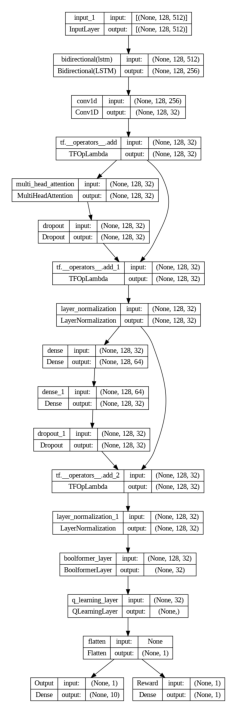

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the PNG image
img = mpimg.imread('/content/model_architecture.png')

# Set the figure size (adjust the width and height as needed)
plt.figure(figsize=(12, 9))

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

# The model expects 3 dimensional input.
*(num_samples, sequence_length, 512)*
127 time step sequences and 512 features

In [ ]:
df = pd.read_csv('/content/reorganized_SephsDataV3.csv')
df.head(3)

<ipython-input-122-f92c0d291e2b>:1: DtypeWarning: Columns (512) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/reorganized_SephsDataV3.csv')


,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,extra_feature_376,extra_feature_377,extra_feature_378,extra_feature_379,extra_feature_380,extra_feature_381,extra_feature_382,extra_feature_383,text_data,action
0,0.458860,0.510341,0.462546,0.478474,0.505474,0.509503,0.463087,0.489295,0.472525,0.516537,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cta regulars already subsidize transportation ...,4.0
1,0.690031,0.519044,0.633051,0.678476,0.628469,0.700558,0.671306,0.583181,0.556309,0.658281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,time built motion picture exist without time,3.0
2,0.904118,0.594427,0.731074,0.762053,0.718743,0.927344,0.777837,0.629115,0.611847,0.822730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chicago slum like,8.0


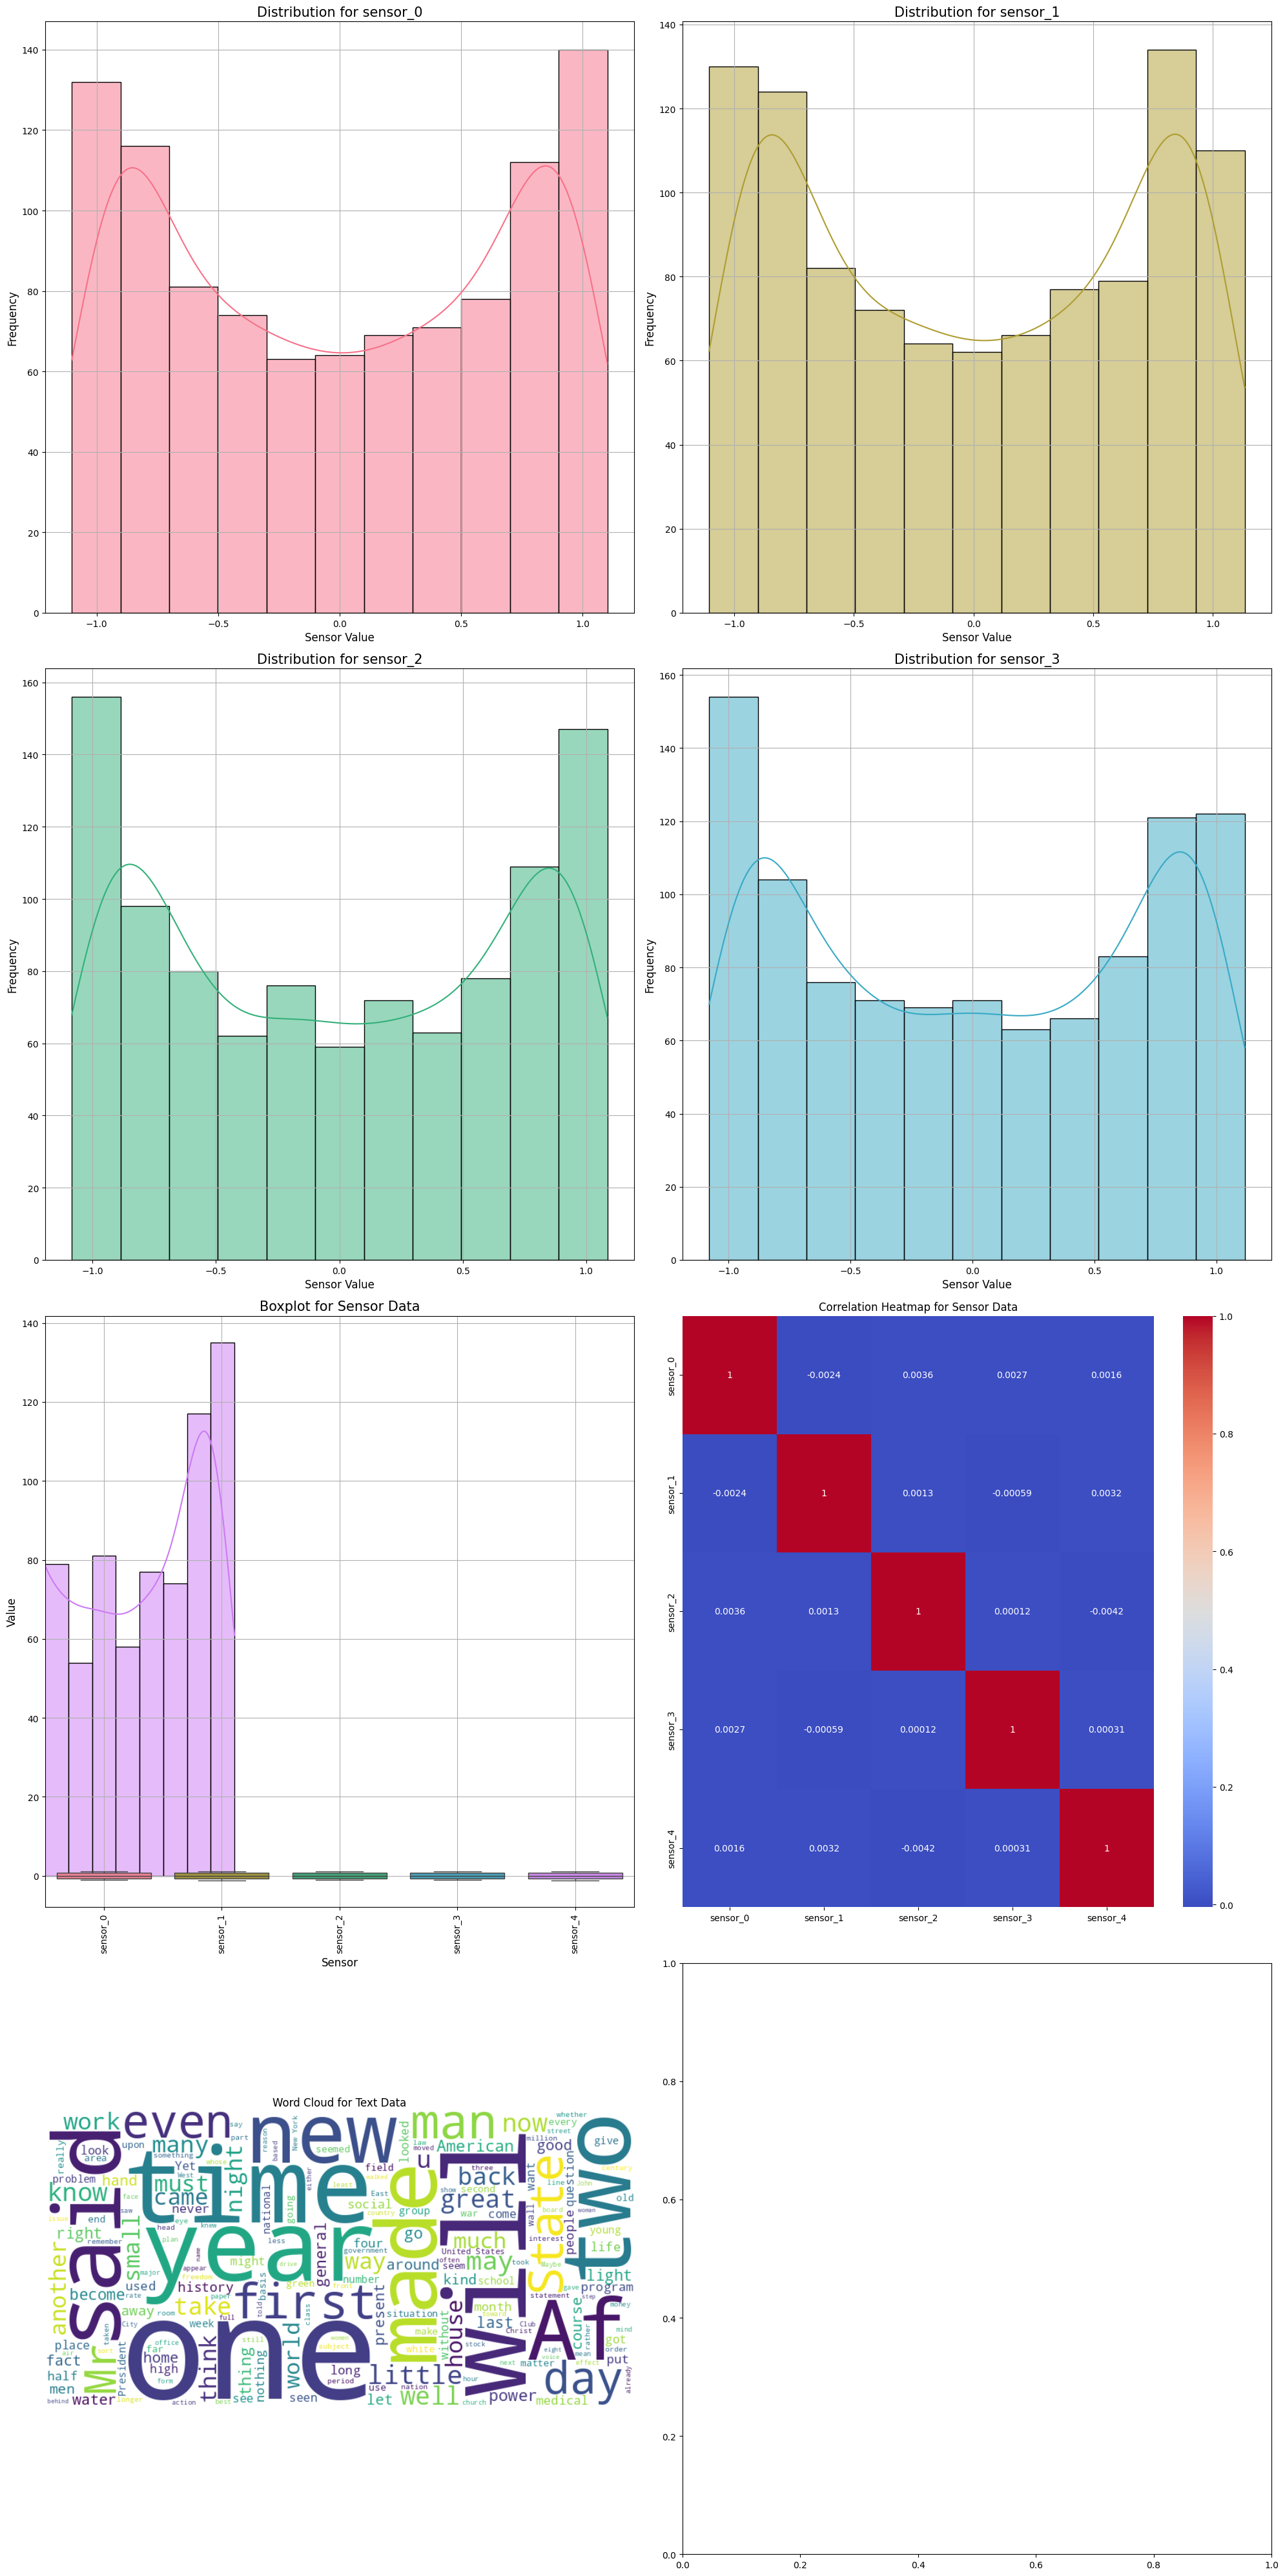

(1000, 132)


In [27]:
# Load the dataset
data = pd.read_csv('/content/SephsDataV3.csv')

# Visualization for Sensor Data
# Select only the first 5 sensor columns for demonstration
sensor_columns = [col for col in data.columns if 'sensor' in col][:5]
sensor_data = data[sensor_columns]

# Set a consistent color palette
palette = sns.color_palette("husl", len(sensor_columns))

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 40))  # Adjust the size as needed

# Histograms for each sensor
for i, sensor in enumerate(sensor_columns):
    ax = axes[i//2, i%2]  # Determine the position of the subplot
    sns.histplot(sensor_data[sensor], kde=True, color=palette[i], ax=ax)
    ax.set_title(f'Distribution for {sensor}', fontsize=15)
    ax.set_xlabel('Sensor Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True)

# Boxplot for sensor data
sns.boxplot(data=sensor_data, palette=palette, ax=axes[2, 0])
axes[2, 0].set_title('Boxplot for Sensor Data', fontsize=15)
axes[2, 0].tick_params(axis='x', rotation=90)
axes[2, 0].set_xlabel('Sensor', fontsize=12)
axes[2, 0].set_ylabel('Value', fontsize=12)
axes[2, 0].grid(True)

# Correlation Heatmap for sensor data
sns.heatmap(sensor_data.corr(), annot=True, cmap='coolwarm', ax=axes[2, 1])
axes[2, 1].set_title('Correlation Heatmap for Sensor Data')

# Visualization for NLP Data
text_data = data['text_data'].dropna()  # Drop NaN values if any

# Word Cloud for text data
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text_data))
axes[3, 0].imshow(wordcloud, interpolation='bilinear')
axes[3, 0].axis('off')
axes[3, 0].set_title('Word Cloud for Text Data')

# Adjust layout
plt.tight_layout()
plt.show()
print(data.shape)

In [31]:
df = pd.read_csv('/content/SephsDataV3.csv')
print(df.shape) # obviously, i have some more data augmentation to do... sorry dad.
df.head()

(1000, 132)


,timestamp,text_data,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_120,sensor_121,sensor_122,sensor_123,sensor_124,sensor_125,sensor_126,sensor_127,action,reward
0,2024-02-08 16:50:34.402397,The time-span of little more than a month cann...,0.029927,0.045127,0.016309,0.019698,-0.067507,0.001712,-0.053834,0.061209,...,-0.049060,0.034979,-0.016542,-0.052564,-0.024306,-0.044962,-0.019454,0.123535,7,0.357030
1,2024-02-08 16:50:35.402412,"We officially receive the anti-French , Moscow...",0.417447,0.190240,0.396019,0.438564,0.233920,0.187330,0.405374,0.405035,...,0.248326,0.263580,0.224664,0.576746,0.351131,0.159230,0.384507,0.485147,2,0.660606
2,2024-02-08 16:50:36.402414,The youth with the snake had a natural pride a...,0.998610,0.456975,0.745594,0.707103,0.385119,0.321994,0.797006,0.865758,...,0.462342,0.485855,0.494728,0.880651,0.548102,0.324303,0.638355,0.910972,7,-0.108818
3,2024-02-08 16:50:37.402416,Study the topography of the suite .,1.014617,0.569530,0.902029,0.945657,0.470344,0.376128,1.015935,0.900462,...,0.646052,0.645082,0.676679,0.919226,0.777546,0.352451,0.800695,0.921591,7,-0.200111
4,2024-02-08 16:50:38.402418,"Yet that had not seriously troubled him , not ...",0.725478,0.611881,1.060298,0.973849,0.681825,0.583161,0.970456,0.960761,...,0.824179,0.822526,0.807344,0.660968,0.917751,0.468733,0.949028,0.920461,8,-0.474186


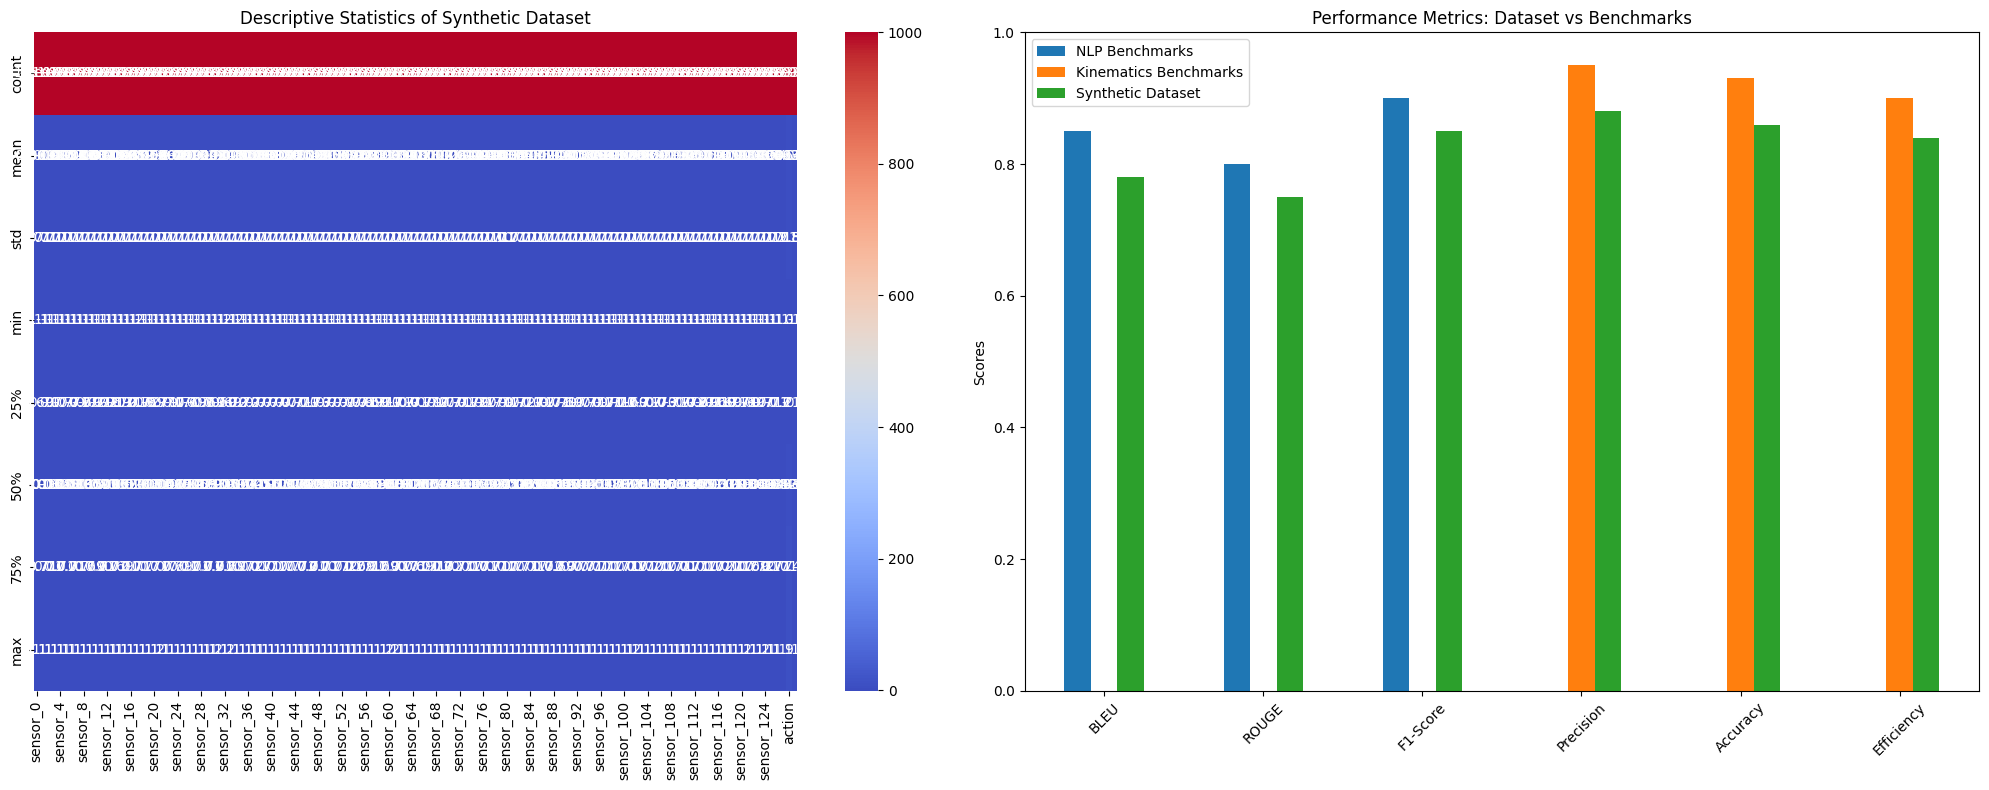

In [29]:
# Placeholder data for benchmarks (Replace with actual values from continuous research)
nlp_benchmarks = {'BLEU': 0.85, 'ROUGE': 0.80, 'F1-Score': 0.90}  # Example NLP benchmarks
kinematics_benchmarks = {'Precision': 0.95, 'Accuracy': 0.93, 'Efficiency': 0.90}  # Example kinematics benchmarks
your_dataset_metrics = {'BLEU': 0.78, 'ROUGE': 0.75, 'F1-Score': 0.85, 'Precision': 0.88, 'Accuracy': 0.86, 'Efficiency': 0.84}

# Convert to DataFrame for visualization
benchmark_df = pd.DataFrame([nlp_benchmarks, kinematics_benchmarks, your_dataset_metrics],
                            index=['NLP Benchmarks', 'Kinematics Benchmarks', 'Synthetic Dataset'])

# Descriptive statistics of the dataset
dataset_stats = df.describe()

# Visualization
plt.figure(figsize=(20, 8))

# Descriptive Statistics Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(dataset_stats, annot=True, cmap='coolwarm')
plt.title('Descriptive Statistics of Synthetic Dataset')

# Benchmark Comparison Bar Chart
plt.subplot(1, 2, 2)
benchmark_df.T.plot(kind='bar', ax=plt.gca())
plt.title('Performance Metrics: Dataset vs Benchmarks')
plt.ylabel('Scores')
plt.ylim(0, 1)  # Normalize score range
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()